## Multi-class Classification

We've referenced the TinyVGG architecture from the CNN Explainer website multiple times through this notebook, however, the CNN Explainer website works with 10 different image classes, where as our current model only works with two classes (pizza and steak).

> 🛠 **Practice:** Before scrolling down, how do you think we might change our model to work with 10 classes of the same kind of images? Assume the data is in the same style as our two class problem.

Remember the steps we took before to build our pizza 🍕 vs. steak 🥩 classifier?

How about we go through those steps again, except this time, we'll work with 10 different types of food.

1. Become one with the data (visualize, visualize, visualize...)
2. Preprocess the data (prepare it for a model)
3. Create a model (start with a baseline)
4. Fit the model
5. Evaluate the model
6. Adjust different parameters and improve model (try to beat your baseline)
7. Repeat until satisfied

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/misc-tensorflow-workflow-outline.png)
*The workflow we're about to go through is a slightly modified version of the above image. As you keep going through deep learning problems, you'll find the workflow above is more of an outline than a step-by-step guide.*

In [38]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

### 1. Import and become one with the data

Again, we've got a subset of the [Food101 dataset](https://www.kaggle.com/dansbecker/food-101). In addition to the pizza and steak images, we've pulled out another eight classes.


In [39]:
!pwd

/d/ML/tensorflow-deep-learning/practices


In [40]:
dataset_name= '10_food_classes_all_data'

In [44]:
import pathlib
train_dir = pathlib.Path(dataset_name+'/train/')
# Get the classes name of the image in train dataset
train_classes = np.array(sorted([item.name for item in train_dir.glob('*')]))
len(train_classes),train_classes

(10,
 array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
        'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
       dtype='<U14'))

In [45]:
test_dir = pathlib.Path(dataset_name+'/test/')
# Get the classes name of the image in test dataset
test_classes = np.array(sorted([item.name for item in test_dir.glob('*')]))
len(test_classes),test_classes

(10,
 array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
        'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
       dtype='<U14'))

In [47]:
# Check the different in train and test dataset
train_classes == test_classes

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [48]:
# Create the function to view random image
import matplotlib.image as mpimg
import random

def view_random_image(target_dir,target_class):
    '''
    Take a random image in target directory
    Arguments:
    target_dir --- the directory into image
    target_class --- the class name of image
    Returns:
    img --- the image in numpy array uint8
    '''
    # Setup target directory 
    target_folder = target_dir + target_class
    # Get a random image path
    random_image = random.sample(os.listdir(target_folder),1)
    # Read in the image and plot it using matplotlib
    img = mpimg.imread(target_folder + '/' + random_image[0])
    # Show the image
    plt.imshow(img)
    plt.title(target_class)
    plt.axis('off')
    print(f'Image shape: {img.shape}') # Show the image shape
    return img

Image shape: (512, 512, 3)


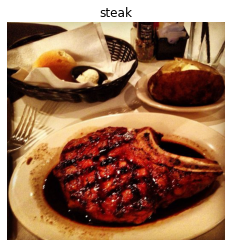

In [53]:
random_number = np.random.randint(len(train_classes)) #train_classes[]
random_class = train_classes[random_number]
img = view_random_image(target_dir = dataset_name + '/train/', target_class = random_class)

### 2. Preprocess the data (prepare it for a model)

After going through a handful of images (it's good to visualize at least 10-100 different examples), it looks like our data directories are setup correctly.

Time to preprocess the data.

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the random seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [11]:
# Setup the train and test directories
train_dir = dataset_name + '/train'
test_dir = dataset_name + '/test'

# Import data from directories and turn it into tensor
train_data = train_datagen.flow_from_directory(train_dir,
                          batch_size = 32,
                          target_size = (224,224),
                          class_mode = 'categorical',
                          seed = 42
                          )

test_data = test_datagen.flow_from_directory(test_dir,
                                            batch_size = 32,
                                            target_size = (224,224),
                                            class_mode = 'categorical',
                                            seed = 42
                                            )

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [12]:
train_data.image_shape

(224, 224, 3)

In [13]:
len(train_classes)

10

### 3. Create a model (start with a baseline)

We can use the same model (TinyVGG) we used for the binary classification problem for our multi-class classification problem with a couple of small tweaks.

Namely:
* Changing the output layer to use have 10 ouput neurons (the same number as the number of classes we have).
* Changing the output layer to use `'softmax'` activation instead of `'sigmoid'` activation.
* Changing the loss function to be `'categorical_crossentropy'` instead of `'binary_crossentropy'`.

In [23]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(input_shape = train_data.image_shape,
                         filters = 10,
                         kernel_size = (3,3),
                         activation = 'relu',
                         ),
    tf.keras.layers.Conv2D(filters = 10,
                          kernel_size = (3,3),
                           activation = 'relu'
                          ),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(filters = 10,
                          kernel_size = (3,3),
                           activation = 'relu'
                          ),
    tf.keras.layers.Conv2D(filters = 10,
                          kernel_size = (3,3),
                           activation = 'relu'
                          ),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation = 'relu'),
    tf.keras.layers.Dense(len(train_classes),activation = 'softmax'),
])

In [24]:
model_1.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ['accuracy']
               )

### 4. Fit a model

Now we've got a model suited for working with multiple classes, let's fit it to our data.

In [25]:
history = model_1.fit(train_data,
            epochs = 3,
            steps_per_epoch = len(train_data),
            validation_data = test_data,
            validation_steps = len(test_data)
           )

Epoch 1/3
235/235 [==============================] - 689s 3s/step - loss: 2.1237 - accuracy: 0.2208 - val_loss: 1.9823 - val_accuracy: 0.2900
Epoch 2/3
235/235 [==============================] - 718s 3s/step - loss: 1.8463 - accuracy: 0.3485 - val_loss: 1.8441 - val_accuracy: 0.3608
Epoch 3/3
235/235 [==============================] - 665s 3s/step - loss: 1.5636 - accuracy: 0.4644 - val_loss: 1.7943 - val_accuracy: 0.3780


### 5. Evaluate the model

Woohoo! We've just trained a model on 10 different classes of food images, let's see how it went.

In [30]:
model_1.evaluate(test_data)

79/79 [==============================] - 52s 659ms/step - loss: 1.7943 - accuracy: 0.3780


[1.7943371534347534, 0.3779999911785126]

In [28]:
# Plot the validation training data seperately
def plot_loss_curves(history):
    '''
    Plot sperate loss curves for training and validation metrics
    '''
    # Get the log values in dictionary history
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(len(history.history['loss']))
    # Plot loss
    plt.plot(epochs,loss,label = 'training_loss')
    plt.plot(epochs,val_loss,label = 'val_loss')
    plt.title('Loss')
    plt.legend()
    # Plot accuracy
    plt.figure() # Create new plot
    plt.plot(epochs,accuracy,label = 'accuracy')
    plt.plot(epochs,val_accuracy,label = 'val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

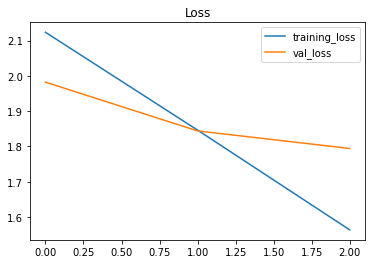

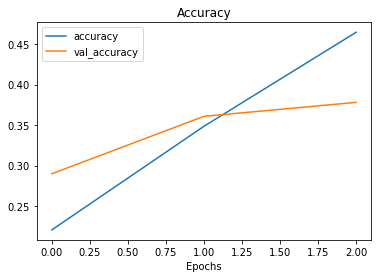

In [29]:
plot_loss_curves(history)

### 6. Adjust the model parameters

Due to its performance on the training data, it's clear our model is learning something. However, performing well on the training data is like going well in the classroom but failing to use your skills in real life.

Ideally, we'd like our model to perform as well on the test data as it does on the training data.

So our next steps will be to try and prevent our model overfitting. A couple of ways to prevent overfitting include:

- **Get more data** - Having more data gives the model more opportunities to learn patterns, patterns which may be more generalizable to new examples.
- **Simplify model** - If the current model is already overfitting the training data, it may be too complicated of a model. This means it's learning the patterns of the data too well and isn't able to generalize well to unseen data. One way to simplify a model is to reduce the number of layers it uses or to reduce the number of hidden units in each layer.
- **Use data augmentation** - Data augmentation manipulates the training data in a way so that's harder for the model to learn as it artificially adds more variety to the data. If a model is able to learn patterns in augmented data, the model may be able to generalize better to unseen data.
- **Use transfer learning** - Transfer learning involves leverages the patterns (also called pretrained weights) one model has learned to use as the foundation for your own task. In our case, we could use one computer vision model pretrained on a large variety of images and then tweak it slightly to be more specialized for food images.

> 🔑 **Note:** Preventing overfitting is also referred to as **regularization**.

If you've already got an existing dataset, you're probably most likely to try one or a combination of the last three above options first.

Since collecting more data would involve us manually taking more images of food, let's try the ones we can do from right within the notebook.

How about we simplify our model first?

To do so, we'll remove two of the convolutional layers, taking the total number of convolutional layers from four to two.

#### Try a simplify model

In [35]:
model_2 =tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters = 10,
                          kernel_size = (3,3),
                          input_shape = train_data.image_shape,
                          activation = 'relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(filters = 10,
                          kernel_size = (3,3),
                          activation = 'relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10,activation = 'softmax')
])

model_2.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ['accuracy'])


In [36]:
history_2 = model_2.fit(train_data,
                       epochs = 5,
                       steps_per_epoch = len(train_data),
                       validation_data = test_data,
                       validation_steps = len(test_data)
                       )

Epoch 1/5
235/235 [==============================] - 256s 1s/step - loss: 2.0893 - accuracy: 0.2512 - val_loss: 1.9510 - val_accuracy: 0.3148
Epoch 2/5
235/235 [==============================] - 285s 1s/step - loss: 1.7652 - accuracy: 0.3947 - val_loss: 1.9213 - val_accuracy: 0.3064
Epoch 3/5
235/235 [==============================] - 294s 1s/step - loss: 1.3908 - accuracy: 0.5448 - val_loss: 1.9490 - val_accuracy: 0.3356
Epoch 4/5
235/235 [==============================] - 295s 1s/step - loss: 0.9514 - accuracy: 0.7060 - val_loss: 2.2745 - val_accuracy: 0.2996
Epoch 5/5
235/235 [==============================] - 299s 1s/step - loss: 0.5505 - accuracy: 0.8433 - val_loss: 2.5629 - val_accuracy: 0.2944


In [55]:
model_2.evaluate(test_data)

79/79 [==============================] - 34s 434ms/step - loss: 2.5629 - accuracy: 0.2944


[2.5629405975341797, 0.29440000653266907]

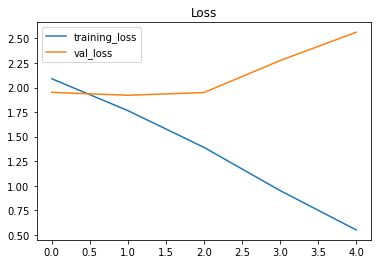

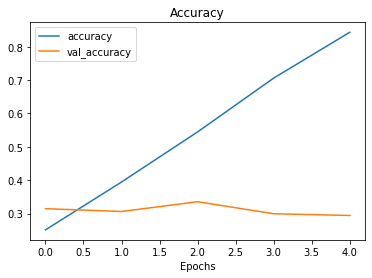

In [56]:
plot_loss_curves(history_2)

Hmm... even with a simplifed model, it looks like our model is still dramatically overfitting the training data.

What else could we try?

How about **data augmentation**?

Data augmentation makes it harder for the model to learn on the training data and in turn, hopefully making the patterns it learns more generalizable to unseen data.

To create augmented data, we'll recreate a new [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) instance, this time adding some parameters such as `rotation_range` and `horizontal_flip` to manipulate our images.

#### Data augmentation

In [57]:
train_datagen_augmented = ImageDataGenerator(rescale = 1./255,
                                            rotation_range = 20, # this is a int not a float
                                            width_shift_range = 0.2,
                                            height_shift_range = 0.2,
                                            zoom_range = 0.2,
                                            horizontal_flip = True
                                            )

train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                  target_size = (224,224),
                                                                  batch_size = 32,
                                                                  class_mode = 'categorical')

Found 7500 images belonging to 10 classes.


In [61]:
# Clone the model (use the same architecture)
model_3 = tf.keras.models.clone_model(model_2)

model_3.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ['accuracy']
               )

In [62]:
# Fit the model
history_3 = model_3.fit(train_data_augmented,
           epochs = 5,
           steps_per_epoch = len(train_data_augmented),
           validation_data = test_data,
           validation_steps = len(test_data)
           )

Epoch 1/5
235/235 [==============================] - 483s 2s/step - loss: 2.1943 - accuracy: 0.1973 - val_loss: 2.0149 - val_accuracy: 0.3016
Epoch 2/5
235/235 [==============================] - 449s 2s/step - loss: 2.0723 - accuracy: 0.2671 - val_loss: 1.9217 - val_accuracy: 0.3416
Epoch 3/5
235/235 [==============================] - 508s 2s/step - loss: 2.0248 - accuracy: 0.2928 - val_loss: 1.8894 - val_accuracy: 0.3512
Epoch 4/5
235/235 [==============================] - 487s 2s/step - loss: 1.9877 - accuracy: 0.3127 - val_loss: 1.8270 - val_accuracy: 0.3816
Epoch 5/5
235/235 [==============================] - 446s 2s/step - loss: 1.9653 - accuracy: 0.3180 - val_loss: 1.8136 - val_accuracy: 0.3828


In [63]:
model_3.evaluate(test_data)

79/79 [==============================] - 37s 468ms/step - loss: 1.8136 - accuracy: 0.3828


[1.813590407371521, 0.38280001282691956]

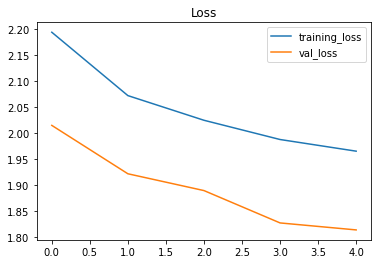

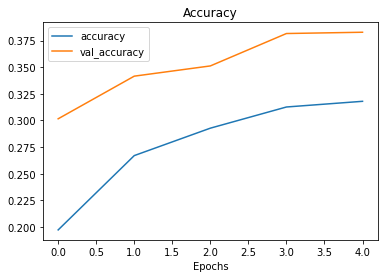

In [64]:
# Evaluate model
plot_loss_curves(history_3)

### 7. Repeat until satisfied

We could keep going here. Restructuring our model's architecture, adding more layers, trying it out, adjusting the learning rate, trying it out, trying different methods of data augmentation, training for longer. But as you could image, this could take a fairly long time.

Good thing there's still one trick we haven't tried yet and that's **transfer learning**.

However, we'll save that for the next notebook where you'll see how rather than design our own models from scratch we leverage the patterns another model has learned for our own task.

In the meantime, let's make a prediction with our trained multi-class model.

### 8. Making a prediction with our trained model

What good is a model if you can't make predictions with it?

Let's first remind ourselves of the classes our multi-class model has been trained on and then we'll download some of own custom images to work with.

In [65]:
# Create a function to import an image and resize it to be able to used with our model
def load_and_prep_image(filename, img_shape = 224):
    '''
    Reads an image from filename, turns it into a  tensor, and reshape it into (img_shape,img_shape,color_channel)
    Arguments:
    filenames --- the file's path
    img_shape --- the shape of image
    Return:
    img --- the preprocessed image
    '''
    # Read in target file (an image)
    img = tf.io.read_file(filename)
    
    # Decode the read file into tensor & ensure 3 color channels
    # our model is trained on images with 3 color channels and sometimes images have 3 color channels
    img = tf.image.decode_image(img,channels = 3)
    
    # Resize the image (to the same size we was trained on)
    img = tf.image.resize(img,size = [img_shape,img_shape])
    
    # Normalize image 
    img = img/255
    
    return img

Text(0.5, 1.0, 'preprocessed image')

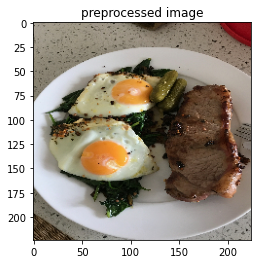

In [69]:
# Load and preprocess our custom image
steak = load_and_prep_image('03-steak.jpeg')
plt.imshow(steak)
plt.title('preprocessed image')

In [99]:
preds = model_3.predict(tf.expand_dims(steak,axis = 0))
preds = tf.squeeze(preds)
print(preds)
max_val = tf.math.reduce_max(preds)
indexs = tf.equal(preds,max_val)
index_max = tf.squeeze(tf.where(indexs))
index_max.numpy()
pred_label = train_classes[index_max.numpy()]
print(pred_label)

tf.Tensor(
[0.03514667 0.07178171 0.06516802 0.18740745 0.08821717 0.04422859
 0.0102934  0.08774779 0.35577276 0.05423652], shape=(10,), dtype=float32)
steak


In [105]:
def pred_and_plot(model,filename,class_names):
    '''
    Imports an image located at filename, make prediction on it with
    a trained model and plots the image with the predicted class as the title
    '''
    # Import the target image and preprocess it
    img = load_and_prep_image(filename)
    # Make a prediction
    pred = model.predict(tf.expand_dims(img,axis = 0))
    # Get the predicted class
    if len(pred[0]) >1: # check for multi-class
        pred_class =class_names[pred.argmax()] # if more than one output, take the max
    else:
        pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output,round
    # Plot the image and predicted class
    plt.imshow(img)
    plt.title(f'Prediction: {pred_class}')
    plt.axis(False)

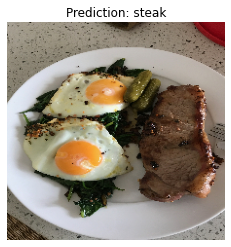

In [106]:
pred_and_plot(model_3,'03-steak.jpeg',train_classes)

tf.Tensor(
[0.03514667 0.07178171 0.06516802 0.18740745 0.08821717 0.04422859
 0.0102934  0.08774779 0.35577276 0.05423652], shape=(10,), dtype=float32)


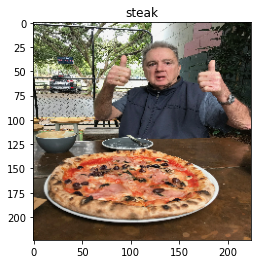

In [104]:
pred_and_plot(model_3,'03-pizza.jpeg',train_classes)

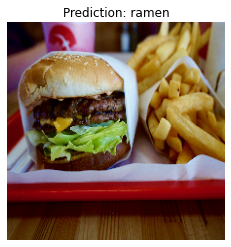

In [108]:
pred_and_plot(model_3,'03-hamburger.jpeg',train_classes)

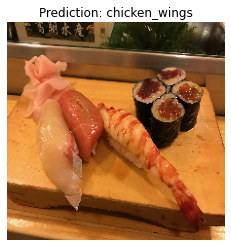

In [109]:
pred_and_plot(model_3,'03-sushi.jpeg',train_classes)

### 9. Saving and loading our model

Once you've trained a model, you probably want to be able to save it and load it somewhere else.

To do so, we can use the [`save`](https://www.tensorflow.org/tutorials/keras/save_and_load) and [`load_model`](https://www.tensorflow.org/tutorials/keras/save_and_load) functions.

https://www.tensorflow.org/tutorials/images/data_augmentation

In [ ]:
# Save a model
model_3.save('10_foods')

In [ ]:
# Load in a model and evaluate it
loaded_model = tf.keras.models.load_model('10_foods')
loaded_model.evaluate(test_data)

## Try other multi-class dataset Mnist

In [111]:
(X_train,y_train),(X_test,y_test) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 2s 0us/step


In [115]:
print(f'X_train.shape: {X_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'y_test.shape: {y_test.shape}')

X_train.shape: (60000, 28, 28)
X_test.shape: (10000, 28, 28)
y_train.shape: (60000,)
y_test.shape: (10000,)


(28, 28)


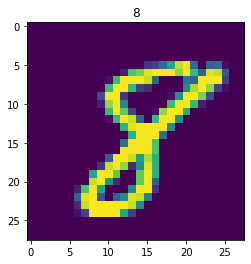

In [134]:
# Visualize the data
random_number = np.random.randint(0,len(X_train))
plt.imshow(X_train[random_number])
plt.title(y_train[random_number])
print(X_train.shape[1:])

In [149]:
# Expand dim
X_train_1 =tf.expand_dims(X_train,axis =-1)
X_test_1 =tf.expand_dims(X_test,axis =-1)

In [169]:
# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters = 32,
                           kernel_size = (3,3),
                          input_shape = (28,28,1),
                          activation = 'sigmoid'),
    tf.keras.layers.Conv2D(filters = 32,
                          kernel_size = (3,3),
                          activation = 'sigmoid'),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation = 'sigmoid'),
    tf.keras.layers.Dense(10,activation = 'softmax')  
])

In [170]:
# Compile the model
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
             optimizer = tf.keras.optimizers.Adam(),
             metrics = ['accuracy']
             )

In [171]:
from keras.utils import np_utils

np_utils.to_categorical(y_train,10)

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [172]:
tf.one_hot(y_train,depth = 10)

<tf.Tensor: shape=(60000, 10), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)>

In [173]:
history = model.fit(X_train_1,tf.one_hot(y_train,depth = 10),
                    validation_data = (X_test_1,tf.one_hot(y_test,depth = 10)),
                    epochs = 5,
                    verbose = 1)

Epoch 1/5
1875/1875 [==============================] - 194s 103ms/step - loss: 0.2523 - accuracy: 0.9301 - val_loss: 0.0671 - val_accuracy: 0.9793
Epoch 2/5
1875/1875 [==============================] - 190s 101ms/step - loss: 0.0529 - accuracy: 0.9846 - val_loss: 0.0506 - val_accuracy: 0.9842
Epoch 3/5
1875/1875 [==============================] - 174s 93ms/step - loss: 0.0342 - accuracy: 0.9900 - val_loss: 0.0359 - val_accuracy: 0.9881
Epoch 4/5
1875/1875 [==============================] - 188s 100ms/step - loss: 0.0233 - accuracy: 0.9935 - val_loss: 0.0341 - val_accuracy: 0.9883
Epoch 5/5
1875/1875 [==============================] - 203s 108ms/step - loss: 0.0159 - accuracy: 0.9955 - val_loss: 0.0367 - val_accuracy: 0.9884


In [174]:
model.evaluate(X_test_1,tf.one_hot(y_test,depth = 10))

313/313 [==============================] - 8s 25ms/step - loss: 0.0367 - accuracy: 0.9884


[0.03674378618597984, 0.9883999824523926]

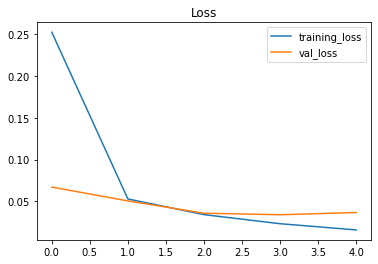

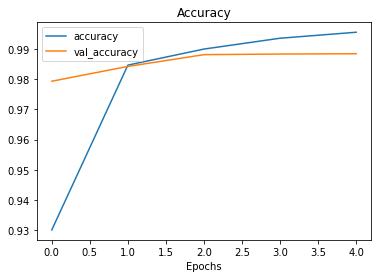

In [175]:
# Plot loss curve
plot_loss_curves(history)

Text(0.5, 1.0, '0')

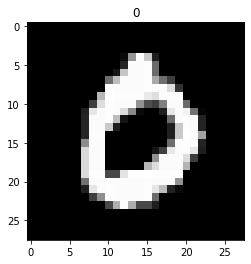

In [202]:
# Predict random
random_number = np.random.randint(len(y_test))
plt.imshow(X_test[random_number],cmap = 'gray')
y_predict = model.predict(tf.expand_dims(X_test_1[random_number],axis = 0))
plt.title(y_predict.argmax())